<a href="https://colab.research.google.com/github/Afix0/BP/blob/main/SDUEBA_007_Bert_agglomerative.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Dependencies
import numpy as np
import pandas as pd
import math
from collections import Counter
# !pip install gensim
# import gensim
# from gensim.models import Word2Vec
from transformers import BertTokenizer, BertModel
from transformers import AutoTokenizer, AutoModel
from sklearn.preprocessing import normalize as sk_normalize
import torch
from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import export_text
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.preprocessing import LabelEncoder
import re
import os
import string
!pip install subgroups
!pip install ucimlrepo
from ucimlrepo import fetch_ucirepo

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.1/274.1 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.5/301.5 kB 25.9 MB/s eta 0:00:00


In [2]:
#SDUEBA Parameters:
"""
vector_space_dimention  ... dimention of the embedding vector space
n_clusters              ... number of clusters to be found
max_depth               ... maximal depth of the decision tree
test_size               ... size of the test set for training the decision tree
mixed_threashold        ... threshold for classifying a cluster as mixed
"""

# vector_space_dimension = 36
n_clusters = 23
clustering_method = "agglomerative"      #"agglomerative"/"spherical_kmeans"

max_depth = 2
test_size = 0.2
mixed_threshold = 0.9
tree_accuracy_threshold = 0.95

#Quality metric parameters
description_length_limit = 2
difference_limit = 0
subgroup_size_limit = 10


In [3]:
#Data augemntation

def preprocess_mushroom_data(df):

    mapping = {
    'cap-shape': {'b': 'bell', 'c': 'conical', 'x': 'convex', 'f': 'flat', 'k': 'knobbed', 's': 'sunken'},
    'cap-surface': {'f': 'fibrous', 'g': 'grooves', 'y': 'scaly', 's': 'smooth'},
    'cap-color': {'n': 'brown', 'b': 'buff', 'c': 'cinnamon', 'g': 'gray', 'r': 'green', 'p': 'pink', 'u': 'purple', 'e': 'red', 'w': 'white', 'y': 'yellow'},
    'bruises': {'t': 'bruises', 'f': 'no bruises'},
    'odor': {'a': 'almond', 'l': 'anise', 'c': 'creosote', 'y': 'fishy', 'f': 'foul', 'm': 'musty', 'n': 'none', 'p': 'pungent', 's': 'spicy'},
    'gill-attachment': {'a': 'attached', 'd': 'descending', 'f': 'free', 'n': 'notched'},
    'gill-spacing': {'c': 'close', 'w': 'crowded', 'd': 'distant'},
    'gill-size': {'b': 'broad', 'n': 'narrow'},
    'gill-color': {'k': 'black', 'n': 'brown', 'b': 'buff', 'h': 'chocolate', 'g': 'gray', 'r': 'green', 'o': 'orange', 'p': 'pink', 'u': 'purple', 'e': 'red', 'w': 'white', 'y': 'yellow'},
    'stalk-shape': {'e': 'enlarging', 't': 'tapering'},
    'stalk-root': {'b': 'bulbous', 'c': 'club', 'u': 'cup', 'e': 'equal', 'z': 'rhizomorphs', 'r': 'rooted', '?': 'missing'},
    'stalk-surface-above-ring': {'f': 'fibrous', 'y': 'scaly', 'k': 'silky', 's': 'smooth'},
    'stalk-surface-below-ring': {'f': 'fibrous', 'y': 'scaly', 'k': 'silky', 's': 'smooth'},
    'stalk-color-above-ring': {'n': 'brown', 'b': 'buff', 'c': 'cinnamon', 'g': 'gray', 'o': 'orange', 'p': 'pink', 'e': 'red', 'w': 'white', 'y': 'yellow'},
    'stalk-color-below-ring': {'n': 'brown', 'b': 'buff', 'c': 'cinnamon', 'g': 'gray', 'o': 'orange', 'p': 'pink', 'e': 'red', 'w': 'white', 'y': 'yellow'},
    'veil-type': {'p': 'partial', 'u': 'universal'},
    'veil-color': {'n': 'brown', 'o': 'orange', 'w': 'white', 'y': 'yellow'},
    'ring-number': {'n': 'none', 'o': 'one', 't': 'two'},
    'ring-type': {'c': 'cobwebby', 'e': 'evanescent', 'f': 'flaring', 'l': 'large', 'n': 'none', 'p': 'pendant', 's': 'sheathing', 'z': 'zone'},
    'spore-print-color': {'k': 'black', 'n': 'brown', 'b': 'buff', 'h': 'chocolate', 'r': 'green', 'o': 'orange', 'u': 'purple', 'w': 'white', 'y': 'yellow'},
    'population': {'a': 'abundant', 'c': 'clustered', 'n': 'numerous', 's': 'scattered', 'v': 'several', 'y': 'solitary'},
    'habitat': {'g': 'grasses', 'l': 'leaves', 'm': 'meadows', 'p': 'paths', 'u': 'urban', 'w': 'waste', 'd': 'woods'}
}

    for column, mapping in mapping.items():
        df[column] = df[column].replace(mapping)

    return df

mapping_targets = {'p': 'poisonous', 'e': 'edible'}

data = fetch_ucirepo(id=73)
features_raw = preprocess_mushroom_data(pd.DataFrame(data=data.data.features))
target_df = pd.DataFrame(data=data.data.targets)
target_df.columns = ['class']
target_df['class'] = target_df['class'].map(mapping_targets)

In [4]:
#Data augemntation sentence creation
features_df = pd.DataFrame()
for column in features_raw.columns:
    split_columns = column.split("-")
    jointed_columns = ' '.join(split_columns)
    features_df[column] = features_raw[column].apply(lambda x: f"{jointed_columns} is {x}")



sentences = []
for i in range(len(features_df)):
    sentence = []
    for word in features_df.iloc[i]:
        sentence.append(word)
    sentences.append(sentence)


In [5]:
def clear_cuda_cache():
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

# Optimized BERT-based sentence embedding
class BertEmbedder:
    def __init__(self, model_name="sentence-transformers/all-MiniLM-L6-v2", device=None, batch_size=16):
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name).to(self.device).half()
        self.batch_size = batch_size

    def get_embedding(self, sentences):
        if isinstance(sentences[0], list):
            sentences = [" ".join(sentence) for sentence in sentences]

        embeddings = []
        for i in range(0, len(sentences), self.batch_size):
            batch = sentences[i:i+self.batch_size]
            inputs = self.tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=256).to(self.device)
            with torch.no_grad():
                outputs = self.model(**inputs)
            embeddings.append(outputs.last_hidden_state[:, 0, :].cpu().numpy())

        return np.vstack(embeddings)

class SentenceEmbedder:
    def __init__(self, bert_embedder):
        self.bert_embedder = bert_embedder

    def generate_embeddings(self, sentences, apply_normalization=False):
        embeddings = self.bert_embedder.get_embedding(sentences)
        return sk_normalize(embeddings, axis=1) if apply_normalization else embeddings

class SphericalKMeans:
    def __init__(self, n_clusters=n_clusters, max_iter=100, tol=1e-4, random_state=None):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state
        self.cluster_centers_ = None

    def fit(self, X):
        np.random.seed(self.random_state)
        X = sk_normalize(X, norm='l2', axis=1)
        indices = np.random.choice(X.shape[0], self.n_clusters, replace=False)
        self.cluster_centers_ = X[indices]

        for _ in range(self.max_iter):
            similarities = X @ self.cluster_centers_.T
            labels = np.argmax(similarities, axis=1)

            new_centroids = np.array([sk_normalize(X[labels == j].mean(axis=0).reshape(1, -1))
                                      if np.any(labels == j) else self.cluster_centers_[j]
                                      for j in range(self.n_clusters)]).squeeze()

            if np.linalg.norm(new_centroids - self.cluster_centers_) < self.tol:
                break

            self.cluster_centers_ = new_centroids

        self.labels_ = labels
        return self

    def predict(self, X):
        X = sk_normalize(X, norm='l2', axis=1)
        similarities = X @ self.cluster_centers_.T
        return np.argmax(similarities, axis=1)

    def fit_predict(self, X):
        self.fit(X)
        return self.labels_

class ClusteringModel:
    def __init__(self, n_clusters, method="spherical_kmeans", random_state=42):
        self.n_clusters = n_clusters
        self.method = method
        self.random_state = random_state
        self.model = self._initialize_model()

    def _initialize_model(self):
        if self.method == "agglomerative":
            return AgglomerativeClustering(n_clusters=self.n_clusters, metric='cosine', linkage='average')
        elif self.method == "spherical_kmeans":
            return SphericalKMeans(n_clusters=self.n_clusters, random_state=self.random_state)
        else:
            raise ValueError("Unsupported clustering method")

    def fit_predict(self, embeddings):
        return self.model.fit_predict(embeddings)

clear_cuda_cache()
bert_embedder = BertEmbedder()
sentence_embedder = SentenceEmbedder(bert_embedder)
embeddings = sentence_embedder.generate_embeddings(sentences, apply_normalization=True)

clustering_model = ClusteringModel(n_clusters, method=clustering_method)
labels = clustering_model.fit_predict(embeddings)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

In [6]:
#Decision tree training
class DecisionTreeTrainer:
    def __init__(self, features_raw, labels, max_depth, subgroup_size_limit, test_size, random_state=73, print_acc=True):
        self.features_raw = features_raw
        self.labels = labels
        self.max_depth = max_depth
        self.subgroup_size_limit = subgroup_size_limit
        self.test_size = test_size
        self.random_state = random_state
        self.print_acc = print_acc

        self.encoder = OneHotEncoder()
        self.decision_trees = {}
        self.accuracies = {}

        self._prepare_data()
        self._train_trees()

    def _prepare_data(self):
        features_classify = self.features_raw.assign(cluster=self.labels)
        X = features_classify.drop(columns=['cluster'])
        X_encoded = self.encoder.fit_transform(X)
        y = features_classify['cluster']

        self.X_df = pd.DataFrame(X_encoded.toarray(), columns=self.encoder.get_feature_names_out())

        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.X_df, y, test_size=self.test_size, random_state=self.random_state, stratify=y
        )

    def _train_trees(self):
        for cluster in sorted(self.y_train.unique()):
            y_train_binary = (self.y_train == cluster).astype(int)
            y_test_binary = (self.y_test == cluster).astype(int)

            clf = DecisionTreeClassifier(max_depth=self.max_depth, min_samples_leaf=self.subgroup_size_limit, random_state=self.random_state)
            clf.fit(self.X_train, y_train_binary)

            self.decision_trees[cluster] = clf

            y_pred = clf.predict(self.X_test)
            accuracy = accuracy_score(y_test_binary, y_pred)
            self.accuracies[cluster] = accuracy

            if self.print_acc:
                print(f"Accuracy for Cluster {cluster}: {accuracy:.4f}")
                print(classification_report(y_test_binary, y_pred))

    def get_trees(self):
        return self.decision_trees

    def get_accuracies(self):
        return self.accuracies

tree_trainer = DecisionTreeTrainer(
    features_raw=features_raw,
    labels=labels,
    max_depth=max_depth,
    subgroup_size_limit=subgroup_size_limit,
    test_size=test_size,
    print_acc=False
)

In [7]:
# Subgroup creation and quality evaluation
def Quality_metric(tp, fp, TP, FP, description_length, description_length_limit, difference_limit, subgroup_size_limit):
    difference = abs(tp / (tp + fp) - (TP / (TP + FP)))
    if difference < difference_limit or description_length > description_length_limit or (tp + fp) < subgroup_size_limit:
        return np.NaN
    return difference / description_length

class ClusterRuleExtractor:
    def __init__(self, data_frame, target_df, mixed_threshold, cluster_labels, feature_names, decision_trees, trees_acc, tree_accuracy_threshold):
        self.data_frame = data_frame
        self.target_df = target_df
        self.mixed_threshold = mixed_threshold
        self.cluster_labels = cluster_labels
        self.feature_names = feature_names
        self.decision_trees = decision_trees
        self.trees_acc = trees_acc
        self.tree_accuracy_threshold = tree_accuracy_threshold

        self.cluster_frequencies = {}
        self.cluster_percentages = {}
        self.rules_dict = {}
        self.unextractable_clusters = []
        self.WRAcc_dict = {}
        self.tp_dict = {}
        self.fp_dict = {}
        self.TP_dict = {}
        self.FP_dict = {}

        self._classify_and_extract_rules()

    def _extract_rules_from_tree(self, tree, node=0, rule_list=None, rule_path=None):
        if rule_list is None:
            rule_list = []
        if rule_path is None:
            rule_path = []

        left_child = tree.tree_.children_left[node]
        right_child = tree.tree_.children_right[node]
        threshold = tree.tree_.threshold[node]
        feature = tree.tree_.feature[node]
        value = tree.tree_.value[node]

        if left_child == -1 and right_child == -1:
            class_probabilities = value[0] / value.sum()
            predicted_class = class_probabilities.argmax()
            if predicted_class == 1:
                rule_list.append(" AND ".join(rule_path))
            return rule_list

        if left_child != -1:
            self._extract_rules_from_tree(tree, left_child, rule_list, rule_path + [f"{self.feature_names[feature]} <= {threshold:.2f}"])

        if right_child != -1:
            self._extract_rules_from_tree(tree, right_child, rule_list, rule_path + [f"{self.feature_names[feature]} > {threshold:.2f}"])

        return rule_list

    def _classify_and_extract_rules(self):
        cluster_class_counts = {}
        for i, cluster in enumerate(self.cluster_labels):
            class_label = self.target_df['class'][i]
            cluster_class_counts.setdefault(cluster, {}).setdefault(class_label, 0)
            cluster_class_counts[cluster][class_label] += 1

        N = len(self.target_df)
        class_counts = {class_: sum(self.target_df['class'] == class_) for class_ in set(self.target_df['class'])}
        cluster_classifications, n_dict = {}, {}

        for cluster, class_counts in sorted(cluster_class_counts.items()):
            total_count = sum(class_counts.values())
            class_percentages = {cls: round(count / total_count, 2) for cls, count in class_counts.items()}
            dominant_class, dominant_count = max(class_counts.items(), key=lambda x: x[1])
            relative_frequency = dominant_count / total_count
            classification = dominant_class if relative_frequency >= self.mixed_threshold else 'mixed'

            cluster_classifications[cluster] = classification
            self.cluster_frequencies[cluster] = total_count
            self.cluster_percentages[cluster] = class_percentages
            self.tp_dict[cluster] = dominant_count
            self.fp_dict[cluster] = total_count - dominant_count
            n_dict[cluster] = total_count

            self.TP_dict[cluster] = class_counts.get(dominant_class, 0)
            self.FP_dict[cluster] = N - self.TP_dict[cluster]

            self.WRAcc_dict[cluster] = ((self.tp_dict[cluster] + self.fp_dict[cluster]) / N) * (self.tp_dict[cluster] / n_dict[cluster] - self.TP_dict[cluster] / N)

            if cluster in self.decision_trees:
                accuracy = self.trees_acc.get(cluster, 0)
                if accuracy < self.tree_accuracy_threshold:
                    self.unextractable_clusters.append(cluster)
                    self.rules_dict[cluster] = ["Accuracy lower than the given threshold"]
                else:
                    rules_list = self._extract_rules_from_tree(self.decision_trees[cluster])
                    self.rules_dict[cluster] = rules_list if rules_list else self.unextractable_clusters.append(cluster)
            else:
                self.unextractable_clusters.append(cluster)



    def print_summary(self):
        print("\nFormatted Cluster Summary:")
        for cluster in sorted(self.cluster_frequencies.keys()):
            percentages_str = ", ".join(f"'{cls}': {perc}" for cls, perc in self.cluster_percentages[cluster].items())
            rules = self.rules_dict.get(cluster, None)

            if rules is None:
                rules = ["No rules extracted"]

            print(f"Cluster {cluster}: support = {self.cluster_frequencies[cluster]}, {percentages_str}, WRAcc = {self.WRAcc_dict[cluster]}")

            for rule in rules:
                print(f"  - {rule}")

        print("\nUnextractable Clusters:", self.unextractable_clusters)


clusters = ClusterRuleExtractor(
    data_frame=features_df,
    target_df=target_df,
    mixed_threshold=mixed_threshold,
    cluster_labels=labels,
    feature_names=list(tree_trainer.X_df.columns),
    decision_trees=tree_trainer.get_trees(),
    trees_acc=tree_trainer.get_accuracies(),
    tree_accuracy_threshold=tree_accuracy_threshold
)
clusters.print_summary()


Formatted Cluster Summary:
Cluster 0: support = 512, 'edible': 1.0, WRAcc = 0.05905122496915729
  - stalk-root_club > 0.50 AND stalk-color-below-ring_white > 0.50
Cluster 1: support = 36, 'poisonous': 1.0, WRAcc = 0.004411678074047246
  - stalk-color-above-ring_cinnamon > 0.50
Cluster 2: support = 96, 'edible': 1.0, WRAcc = 0.011677201311721492
  - stalk-surface-below-ring_scaly > 0.50 AND gill-color_brown > 0.50
Cluster 3: support = 768, 'edible': 1.0, WRAcc = 0.08559790019832916
  - stalk-root_equal > 0.50 AND gill-size_broad > 0.50
Cluster 4: support = 256, 'poisonous': 1.0, WRAcc = 0.030518591569714235
  - odor_pungent > 0.50
Cluster 5: support = 1544, 'edible': 0.89, 'poisonous': 0.11, WRAcc = 0.1371843273184886
  - Accuracy lower than the given threshold
Cluster 6: support = 40, 'poisonous': 0.2, 'edible': 0.8, WRAcc = 0.003919552209099675
  - ring-number_two > 0.50 AND habitat_paths > 0.50
Cluster 7: support = 96, 'edible': 1.0, WRAcc = 0.011677201311721492
  - cap-shape_sunken

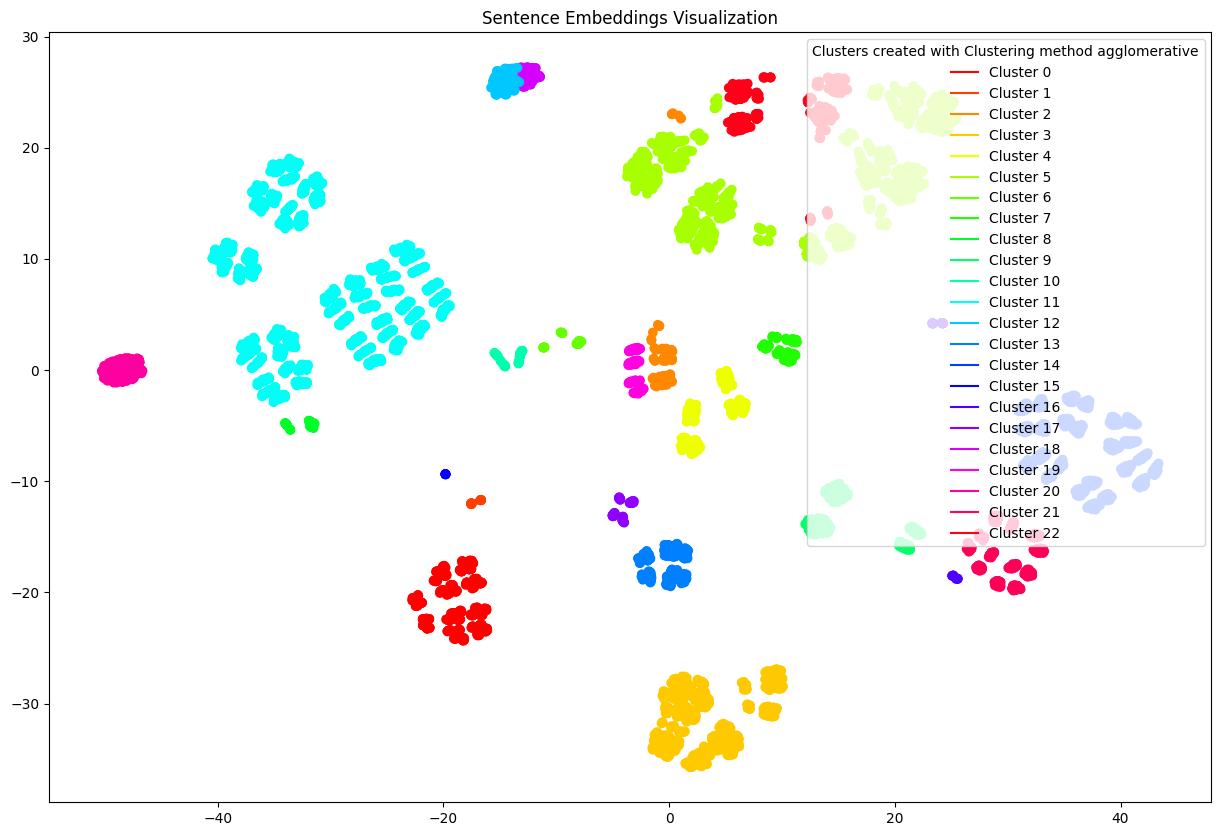

In [8]:
# Clusters visualization
def plot_sentence_embeddings(embeddings, cluster_labels=None, target_labels=None, clustering_method=None):
    plt.figure(figsize=(15, 10))
    tsne = TSNE(n_components=2, random_state= 73, perplexity=300, learning_rate=200, max_iter=1000)
    embeddings_2d = tsne.fit_transform(np.array(embeddings))
    cmap = plt.colormaps['hsv']


    n_clusters = len(set(cluster_labels))
    colors = cmap(np.linspace(0, 1, n_clusters))
    handles = [plt.Line2D([], [], color=color) for color in colors]
    labels = [f"Cluster {i}" for i in range(n_clusters)]
    scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=colors[cluster_labels])

    plt.legend(handles=handles, labels=labels, title=f"Clusters created with {clustering_method}", loc = "upper right")
    plt.title(f"Sentence Embeddings Visualization")
plot_sentence_embeddings(embeddings, cluster_labels=labels, clustering_method=f"Clustering method {clustering_method}")

In [9]:
class SubgroupCreator:
    def __init__(self, X_df, targets_df, target_value):
        self.X_df = X_df
        self.targets_df = targets_df
        self.target_value = target_value
        self.tp_dict = {}
        self.fp_dict = {}
        self.TP_dict = {}
        self.FP_dict = {}
        self.WRAcc_dict = {}
        self.Quality_dict = {}
        self.subgroups = {}
        self.total_coverage = 0

    def evaluate_rule(self, rule_str, covered_indices_set):
        parts = rule_str.split(" AND ")
        mask = pd.Series(True, index=self.X_df.index)

        description = []
        for part in parts:
            feature, operator, value = part.split()
            value = float(value)
            if operator == ">":
                mask &= self.X_df[feature] > value
            elif operator == "<=":
                mask &= self.X_df[feature] <= value
            description.append(f"{feature} {operator} {value}")

        covered_indices = set(self.X_df[mask].index) - covered_indices_set
        covered_indices_set.update(covered_indices)
        covered_targets = self.targets_df.loc[list(covered_indices)]

        tp = (covered_targets == self.target_value).sum().item()
        fp = (covered_targets != self.target_value).sum().item()
        TP = (self.targets_df == self.target_value).sum().item()
        FP = (self.targets_df != self.target_value).sum().item()
        WRAcc = ((tp + fp) / (TP + FP)) * ((tp / (tp + fp)) - (TP / (TP + FP)))

        return tp, fp, TP, FP, WRAcc, covered_indices, description

    def evaluate_all_clusters(self, subgroups):
        with open("results_SDUEBA.txt", "w") as f:
            for cluster, rules_list in subgroups.rules_dict.items():
                if cluster not in subgroups.unextractable_clusters:
                    covered_indices_set = set()

                    for idx, rule_str in enumerate(rules_list):
                        letter_index = string.ascii_lowercase[idx]
                        subgroup_label = f"{cluster}.{letter_index}"

                        tp, fp, TP, FP, WRAcc, covered_indices, description = self.evaluate_rule(rule_str, covered_indices_set)

                        self.tp_dict[subgroup_label] = tp
                        self.fp_dict[subgroup_label] = fp
                        self.TP_dict[subgroup_label] = TP
                        self.FP_dict[subgroup_label] = FP
                        self.WRAcc_dict[subgroup_label] = WRAcc
                        self.subgroups[subgroup_label] = covered_indices
                        self.total_coverage += tp + fp

                        description_str = ", ".join(str(item) for item in description)
                        self.Quality_dict[subgroup_label] = Quality_metric(
                            tp=tp,
                            fp=fp,
                            TP=TP,
                            FP=FP,
                            description_length=len(description),
                            description_length_limit=description_length_limit,
                            difference_limit=difference_limit,
                            subgroup_size_limit=subgroup_size_limit,
                        )

                        f.write(
                            f"Description: [{description_str}], Target: class = '{self.target_value}' ; "
                            f"WRAcc = {float(WRAcc) if WRAcc is not None else 0:.8f} ; "
                            f"Quality Metric = {float(self.Quality_dict[subgroup_label]) if self.Quality_dict[subgroup_label] is not None else 0:.8f} ; "
                            f"tp = {tp} ; fp = {fp} ; TP = {TP} ; FP = {FP}\n"
                        )
            f.write(f"Total coverage: {self.total_coverage / len(self.targets_df)}\n")


evaluator = SubgroupCreator(tree_trainer.X_df, target_df, target_value='edible')
evaluator.evaluate_all_clusters(clusters)


In [10]:
subgroups_to_read = n_clusters*2
with open("./results_SDUEBA.txt", "r") as file:
    while(subgroups_to_read > 0):
        current_line = file.readline()
        print(current_line.strip())
        subgroups_to_read = subgroups_to_read - 1

Description: [stalk-root_club > 0.5, stalk-color-below-ring_white > 0.5], Target: class = 'edible' ; WRAcc = 0.03037895 ; Quality Metric = 0.24101428 ; tp = 512 ; fp = 0 ; TP = 4208 ; FP = 3916
Description: [stalk-color-above-ring_cinnamon > 0.5], Target: class = 'edible' ; WRAcc = -0.00229529 ; Quality Metric = 0.51797144 ; tp = 0 ; fp = 36 ; TP = 4208 ; FP = 3916
Description: [stalk-surface-below-ring_scaly > 0.5, gill-color_brown > 0.5], Target: class = 'edible' ; WRAcc = 0.00379737 ; Quality Metric = 0.24101428 ; tp = 64 ; fp = 0 ; TP = 4208 ; FP = 3916
Description: [stalk-root_equal > 0.5, gill-size_broad > 0.5], Target: class = 'edible' ; WRAcc = 0.04556843 ; Quality Metric = 0.24101428 ; tp = 768 ; fp = 0 ; TP = 4208 ; FP = 3916
Description: [odor_pungent > 0.5], Target: class = 'edible' ; WRAcc = -0.01632209 ; Quality Metric = 0.51797144 ; tp = 0 ; fp = 256 ; TP = 4208 ; FP = 3916
Description: [ring-number_two > 0.5, habitat_paths > 0.5], Target: class = 'edible' ; WRAcc = 0.00

In [11]:
def sort_and_print_top_n(filepath, n):
    try:
        with open(filepath, 'r') as file:
            document = file.read()
    except FileNotFoundError:
        print(f"Error: File not found at '{filepath}'")
        return
    except Exception as e:
        print(f"Error reading file: {e}")
        return

    lines = document.strip().split('\n')
    data = []

    for line in lines:
        if "Total coverage:" in line:
            continue

        match = re.search(r'Quality Metric = ([\d.]+|(?:nan))', line)
        if match:
            quality_metric = match.group(1)
            if quality_metric == 'nan':
                quality_metric = -math.inf
            else:
                quality_metric = float(quality_metric)
            data.append((quality_metric, line))

    sorted_data = sorted(data, key=lambda x: x[0], reverse=True)

    for i in range(min(n, len(sorted_data))):
        print(sorted_data[i][1])

filepath = 'results_SDUEBA.txt'
top_n = n_clusters
sort_and_print_top_n(filepath, top_n)

Description: [stalk-color-above-ring_cinnamon > 0.5], Target: class = 'edible' ; WRAcc = -0.00229529 ; Quality Metric = 0.51797144 ; tp = 0 ; fp = 36 ; TP = 4208 ; FP = 3916
Description: [odor_pungent > 0.5], Target: class = 'edible' ; WRAcc = -0.01632209 ; Quality Metric = 0.51797144 ; tp = 0 ; fp = 256 ; TP = 4208 ; FP = 3916
Description: [stalk-color-below-ring_yellow > 0.5], Target: class = 'edible' ; WRAcc = -0.00153020 ; Quality Metric = 0.51797144 ; tp = 0 ; fp = 24 ; TP = 4208 ; FP = 3916
Description: [gill-color_buff > 0.5], Target: class = 'edible' ; WRAcc = -0.11017413 ; Quality Metric = 0.51797144 ; tp = 0 ; fp = 1728 ; TP = 4208 ; FP = 3916
Description: [spore-print-color_green > 0.5], Target: class = 'edible' ; WRAcc = -0.00459059 ; Quality Metric = 0.51797144 ; tp = 0 ; fp = 72 ; TP = 4208 ; FP = 3916
Description: [cap-shape_sunken > 0.5], Target: class = 'edible' ; WRAcc = 0.00189868 ; Quality Metric = 0.48202856 ; tp = 32 ; fp = 0 ; TP = 4208 ; FP = 3916
Description: [

In [12]:
%%time
from subgroups.algorithms import BSD
from subgroups.quality_measures import WRAcc
from subgroups.quality_measures import WRAccOptimisticEstimate1

dataset = pd.concat([features_raw, target_df], axis=1).astype(str)
target = ('class', 'edible')

bsd_model = BSD(min_support=0, quality_measure=WRAcc(), optimistic_estimate = WRAccOptimisticEstimate1(), num_subgroups=23, max_depth=4, write_results_in_file = True, file_path = "./results_BSD.txt" )
bsd_model.fit(dataset, target)


CPU times: user 28.9 s, sys: 280 ms, total: 29.1 s
Wall time: 29.6 s


In [13]:
def parse_and_compute_quality(file_path, description_length_limit, difference_limit, subgroup_size_limit):
    with open(file_path, 'r') as file:
        for line in file:
            match = re.search(r"(Description: \[.*?\]), (Target: .*? ; Quality Measure WRAcc = ([\d.-]+) ; tp = (\d+) ; fp = (\d+) ; TP = (\d+) ; FP = (\d+))", line)

            if match:
                description = match.group(1)
                details = match.group(2)
                WRAcc = float(match.group(3))
                tp = int(match.group(4))
                fp = int(match.group(5))
                TP = int(match.group(6))
                FP = int(match.group(7))

                description_text = description[13:-1]
                description_length = description_text.count(',') + 1 if description_text else 1

                quality_score = Quality_metric(tp, fp, TP, FP, description_length, description_length_limit, difference_limit, subgroup_size_limit)

                print(f"{description}; Quality Metric = {quality_score if not np.isnan(quality_score) else 'NaN'}; {details}")

file_path = "results_BSD.txt"
parse_and_compute_quality(file_path, description_length_limit, difference_limit, subgroup_size_limit)


Description: [gill-spacing = 'close', odor = 'none']; Quality Metric = 0.21941959429507096; Target: class = 'edible' ; Quality Measure WRAcc = 0.13007444191593573 ; tp = 2304 ; fp = 104 ; TP = 4208 ; FP = 3916
Description: [gill-spacing = 'close', odor = 'none', stalk-surface-above-ring = 'smooth', veil-type = 'partial']; Quality Metric = NaN; Target: class = 'edible' ; Quality Measure WRAcc = 0.1311653613209919 ; tp = 2288 ; fp = 72 ; TP = 4208 ; FP = 3916
Description: [bruises = 'bruises', stalk-surface-above-ring = 'smooth']; Quality Metric = 0.16675685293787873; Target: class = 'edible' ; Quality Measure WRAcc = 0.13268295142669229 ; tp = 2752 ; fp = 480 ; TP = 4208 ; FP = 3916
Description: [odor = 'none', ring-type = 'pendant']; Quality Metric = 0.22456691025940034; Target: class = 'edible' ; Quality Measure WRAcc = 0.13445266512822787 ; tp = 2352 ; fp = 80 ; TP = 4208 ; FP = 3916
Description: [ring-type = 'pendant', stalk-surface-above-ring = 'smooth']; Quality Metric = 0.1493112